# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
# disable python warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Load the data 

In [2]:
path='/Users/yingyuxuan/Desktop/covid19-global-forecasting-week-5/data/'
df=pd.read_csv(path+'covid_19_global_data.csv')
# yingyuxuan is my mom's name  ^.^ 

In [3]:
# shape of our data 
df.shape, len(df)

((858824, 9), 858824)

In [4]:
df.columns
# we can see there are 9 different columns in the train data 

Index(['Id', 'County', 'Province_State', 'Country_Region', 'Population',
       'Weight', 'Date', 'Target', 'TargetValue'],
      dtype='object')

# Data Engineering 

In [5]:
df.Date =  pd.to_datetime(df['Date']) 

In [6]:
# I will analyze ConfirmedCases and Fatalities seperately
df_c=df[df.Target=='ConfirmedCases']
df_f=df[df.Target=='Fatalities']

In [7]:
# get 'Country_Region','TargetValue' columns 
map_df_c=pd.DataFrame(df_c[['Country_Region','TargetValue']].groupby('Country_Region')['TargetValue'].sum()).reset_index().sort_values(by='TargetValue',ascending=False)
map_df_f=pd.DataFrame(df_f[['Country_Region','TargetValue']].groupby('Country_Region')['TargetValue'].sum()).reset_index().sort_values(by='TargetValue',ascending=False)
# merge two dataframes
map_df_merge=pd.merge(map_df_c,map_df_f,on='Country_Region')
map_df_merge.columns=['Country_Region','Confirmed_Cases','Fatalities']

In [8]:
# generate country code  based on country name 
import pycountry
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE 

In [9]:
# create a column for code 
map_df_merge['CODE']=alpha3code(map_df_merge.Country_Region)
map_df_merge.head()

Country_Region  Confirmed_Cases  Fatalities  CODE
0              US        4970430.0    293387.0  None
1          Brazil         374898.0     23473.0   BRA
2          Russia         353427.0      3633.0  None
3  United Kingdom         262547.0     36996.0   GBR
4           Spain         235400.0     26834.0   ESP

In [10]:
# check how many country Codes are not found 
not_found_countries=[]
index=[]
for i in range(len(map_df_merge)):
    if map_df_merge.CODE[i] =='None':
        not_found_countries.append(map_df_merge['Country_Region'][i])
        index.append(i)

In [11]:
print(not_found_countries)
print(index)

['US', 'Russia', 'Iran', 'Korea, South', 'Moldova', 'Bolivia', "Cote d'Ivoire", 'Congo (Kinshasa)', 'Venezuela', 'Kosovo', 'Diamond Princess', 'Tanzania', 'Congo (Brazzaville)', 'Taiwan*', 'West Bank and Gaza', 'Vietnam', 'Burma', 'Brunei', 'Syria', 'Laos', 'Holy See', 'MS Zaandam']
[0, 2, 12, 46, 59, 62, 80, 82, 100, 106, 120, 130, 131, 132, 133, 138, 148, 150, 155, 174, 181, 184]


In [12]:
# find corresponding CODE for the countries in not_found_countries
found_countries_CODE=['USA','RUS','IRN','KOR','MDA','BOL',"CIV",'COG','VEN','XK','None','TZA','COD'
                     ,'TWN','None','VNM','MM','BRN','SYR','LAO','VAT','None']

In [13]:
#replace Nones with found Codes
for i in range(len(index)):
    map_df_merge.CODE.iloc[index[i]]=found_countries_CODE[i]

In [14]:
# only obtian valid country codes
map_df_merge.Country_Region[0]='United States'
map_df_merge.isnull().sum()

Country_Region     0
Confirmed_Cases    0
Fatalities         0
CODE               0
dtype: int64

In [15]:
# Load the world.shp data 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# merge with world.shp data with confirmed cases data and fatalities data
merge=pd.merge(world,map_df_merge,on='CODE')
# merge with data which contains latitude and longitude
merge=merge.merge(pd.read_csv(path+'countries_latitude_longitude.csv'),on='name').sort_values(by='Fatalities',ascending=False).reset_index()


# EDA - World Map 

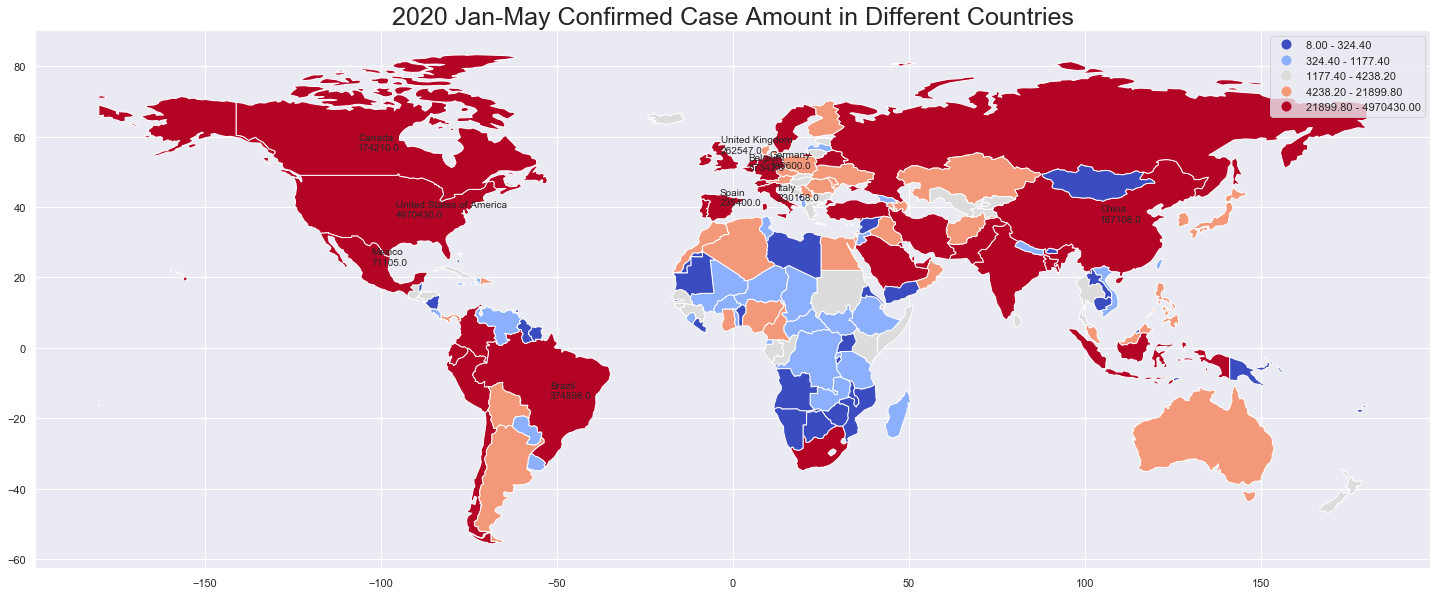

In [39]:
# plot confirmed cases world map 
merge.plot(column='Confirmed_Cases', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='coolwarm')
plt.title('2020 Jan-May Confirmed Case Amount in Different Countries',fontsize=25)
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge.Confirmed_Cases[i]),size=10)


plt.show()

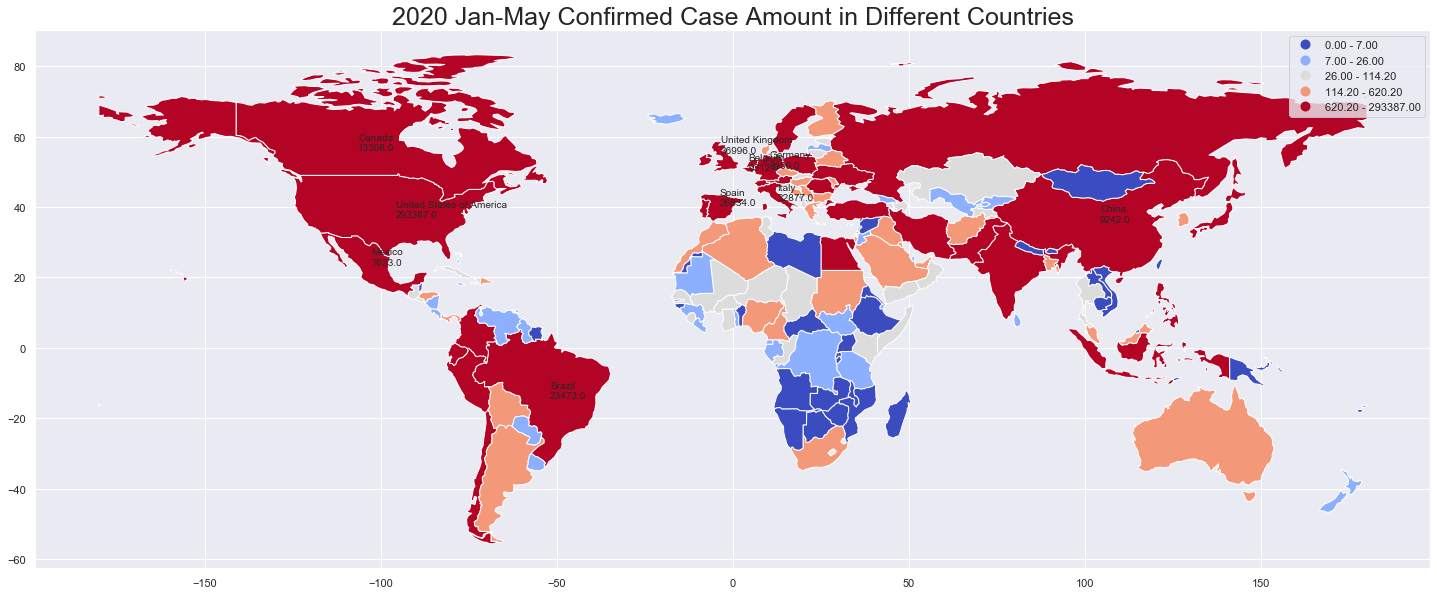

In [40]:
# plot fatalities world map 

merge.plot(column='Fatalities', scheme="quantiles",figsize=(25, 20),legend=True,cmap='coolwarm')
plt.title('2020 Jan-May Confirmed Case Amount in Different Countries',fontsize=25)
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge.Fatalities[i]),size=10)
plt.show()

# Top 10 Countries by confirmed cases and fatalities

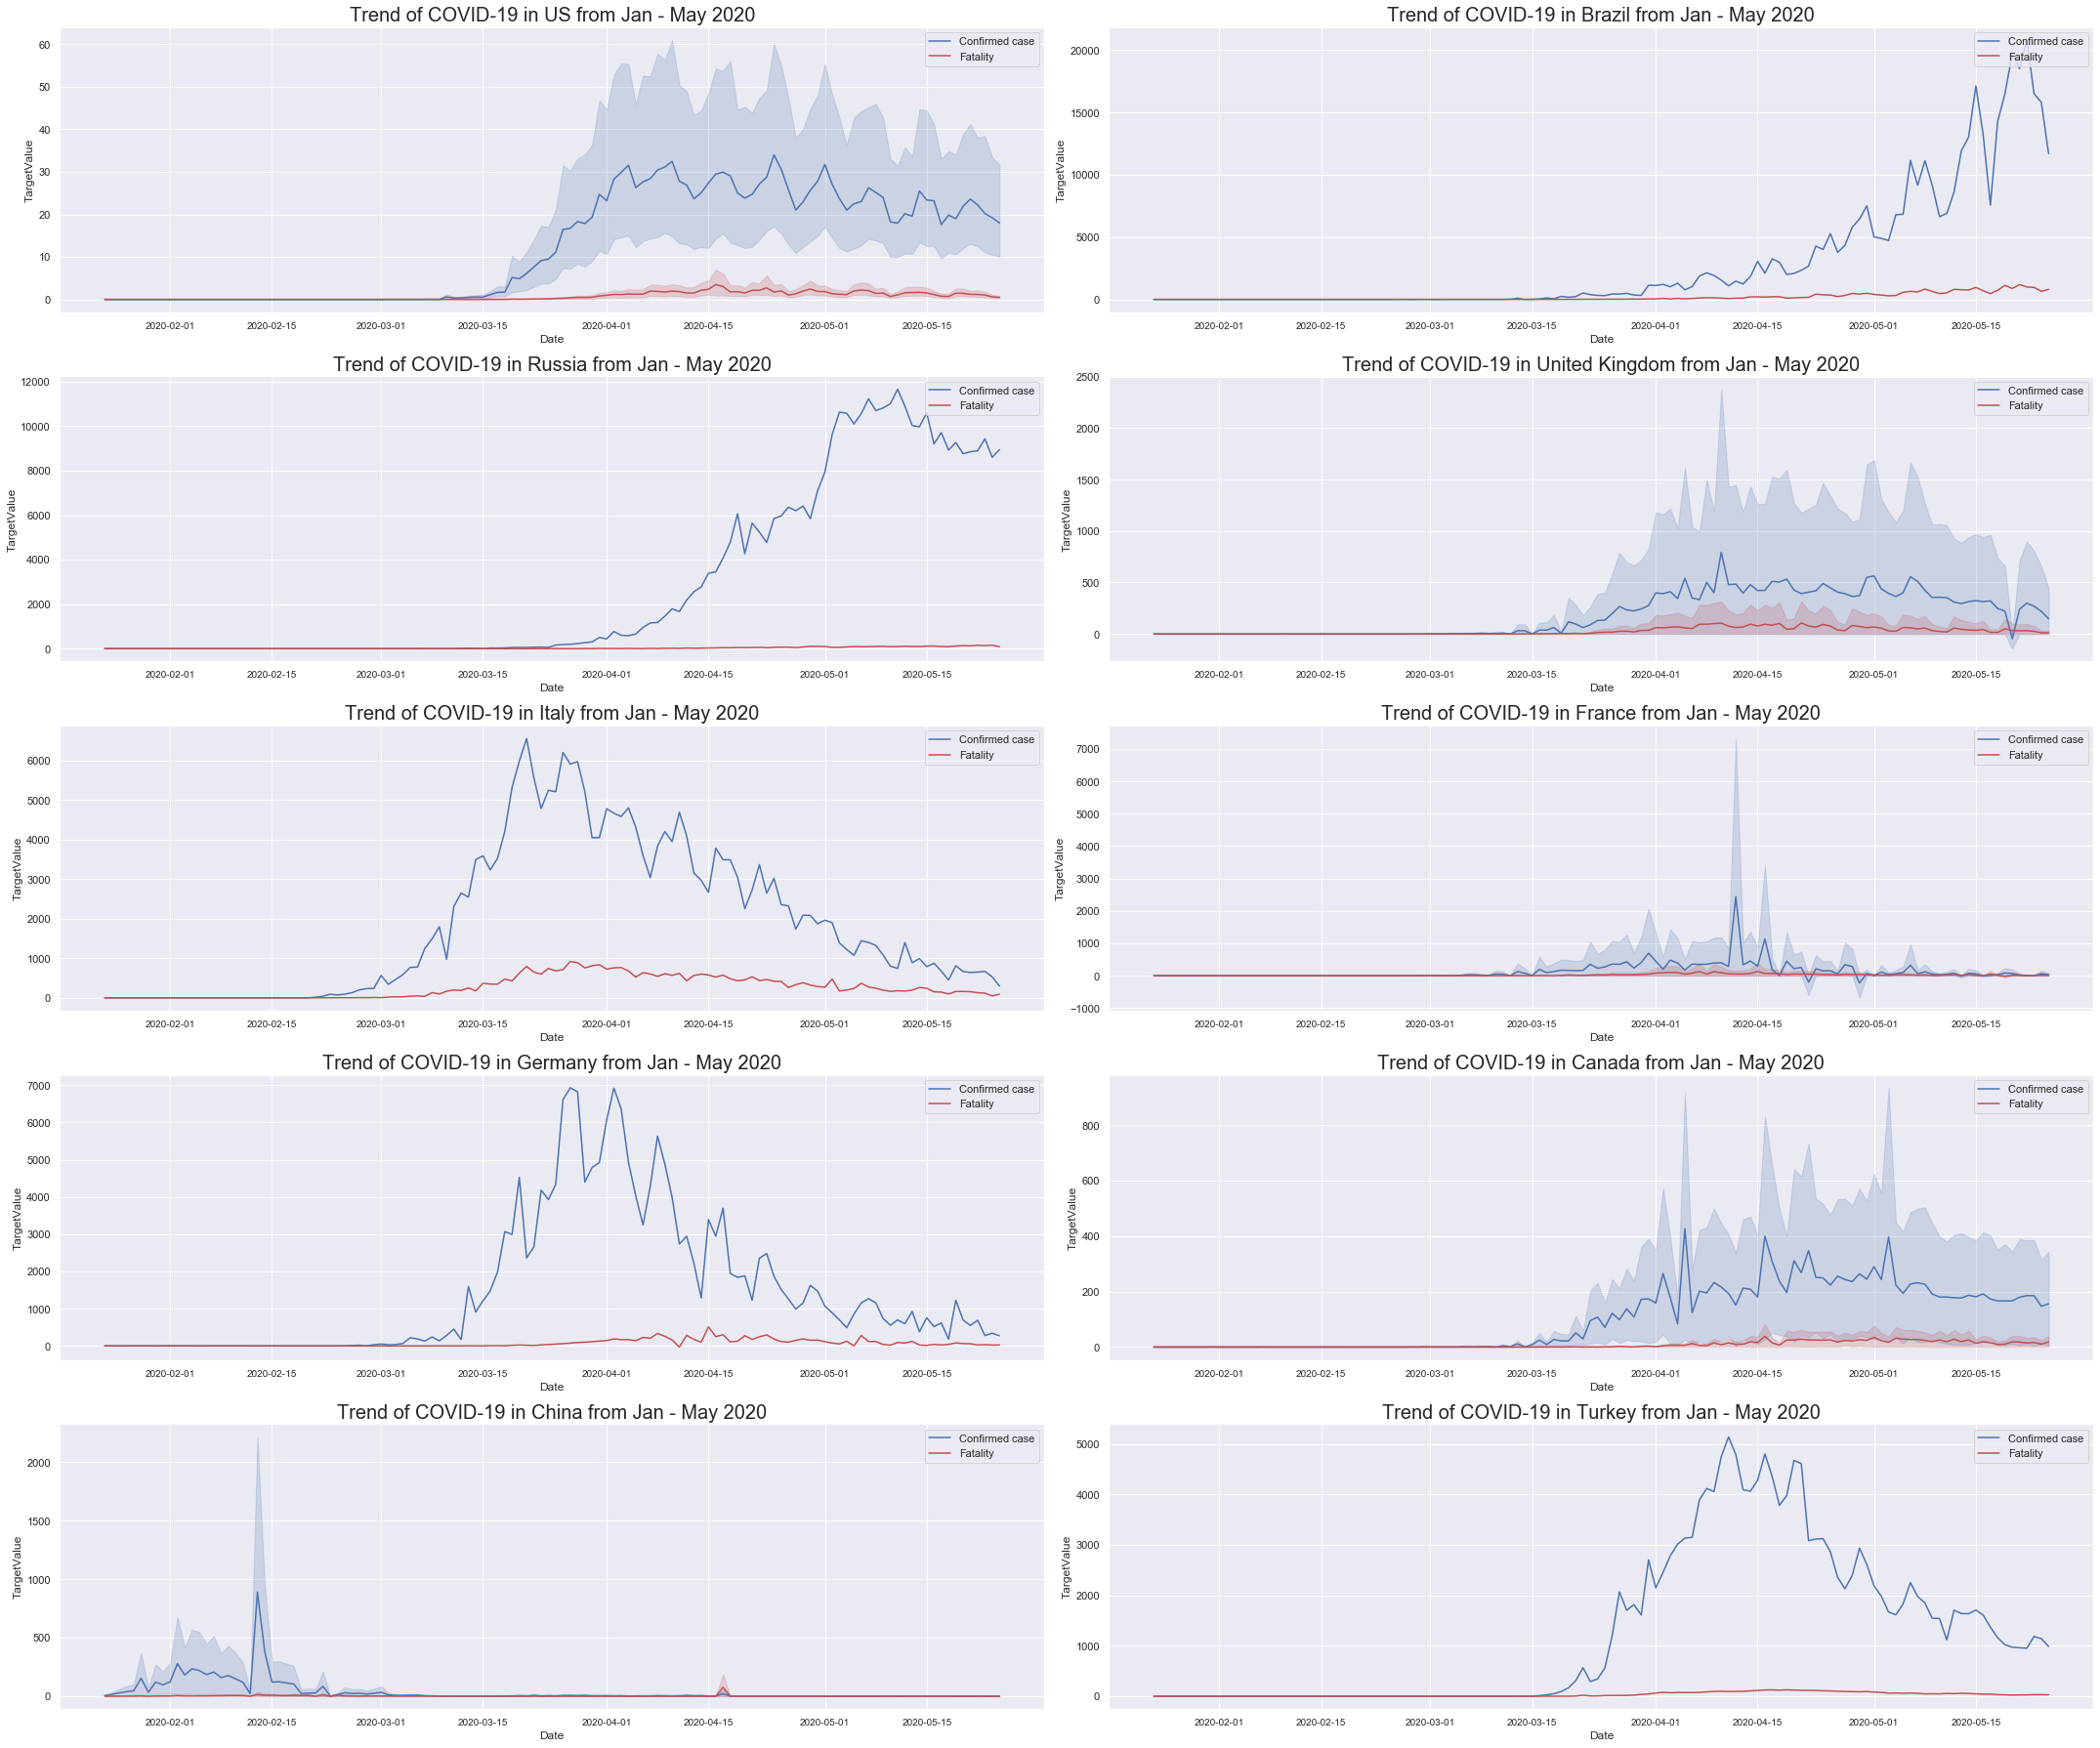

In [18]:
# top 10 countries by confirmed cases
top10_country=['US', 'Brazil', 'Russia', 'United Kingdom', 'Italy', 'France', 'Germany', 'Canada', 'China', 'Turkey']
country_f=df_f[df_f.Country_Region==top10_country[0]]
sum(country_f.TargetValue)
plt.figure(figsize=(30,25))
for i in range(len(top10_country)):
    plt.subplot(5,2,i+1)
    # create dataframes for confirmed cases and fatalities  
    country_c=df_c[df_c.Country_Region==top10_country[i]]
    country_f=df_f[df_f.Country_Region==top10_country[i]]
    # plot using seaborn
    sns.lineplot(country_c.Date,country_c.TargetValue,color='b',label='Confirmed case')
    sns.lineplot(country_f.Date,country_f.TargetValue,color='r',label='Fatality')
    plt.xticks(size=10) 
    plt.legend(loc=1)
    plt.tight_layout(pad=1.0)
    plt.title("Trend of COVID-19 in {} from Jan - May 2020".format(top10_country[i]),fontsize=20)

#  COVID-19  in different continents

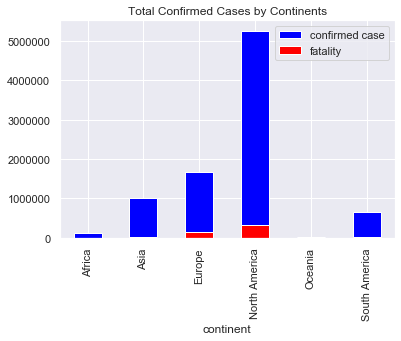

In [19]:
# bar chart for total confirmed cases and fatalities so far in different continents
merge.groupby('continent')['Confirmed_Cases'].sum().plot(kind='bar',title='Total Confirmed Cases by Continents',color='blue',label='confirmed case')
merge.groupby('continent')['Fatalities'].sum().plot(kind='bar',title='Total Confirmed Cases by Continents',color='red',label='fatality')
plt.legend()
plt.show()

In [20]:
# merge df and merge data to obtian date column and other columns together
continent_df=pd.merge(df,merge,on='Country_Region')[[ 'Country_Region', 'Date', 'Target', 'TargetValue','continent']]
continent_df.head()

Country_Region       Date          Target  TargetValue continent
0    Afghanistan 2020-01-23  ConfirmedCases          0.0      Asia
1    Afghanistan 2020-01-23      Fatalities          0.0      Asia
2    Afghanistan 2020-01-24  ConfirmedCases          0.0      Asia
3    Afghanistan 2020-01-24      Fatalities          0.0      Asia
4    Afghanistan 2020-01-25  ConfirmedCases          0.0      Asia

In [21]:
continent_list=list(set(continent_df.continent))
continent_list

['Africa', 'South America', 'North America', 'Asia', 'Oceania', 'Europe']

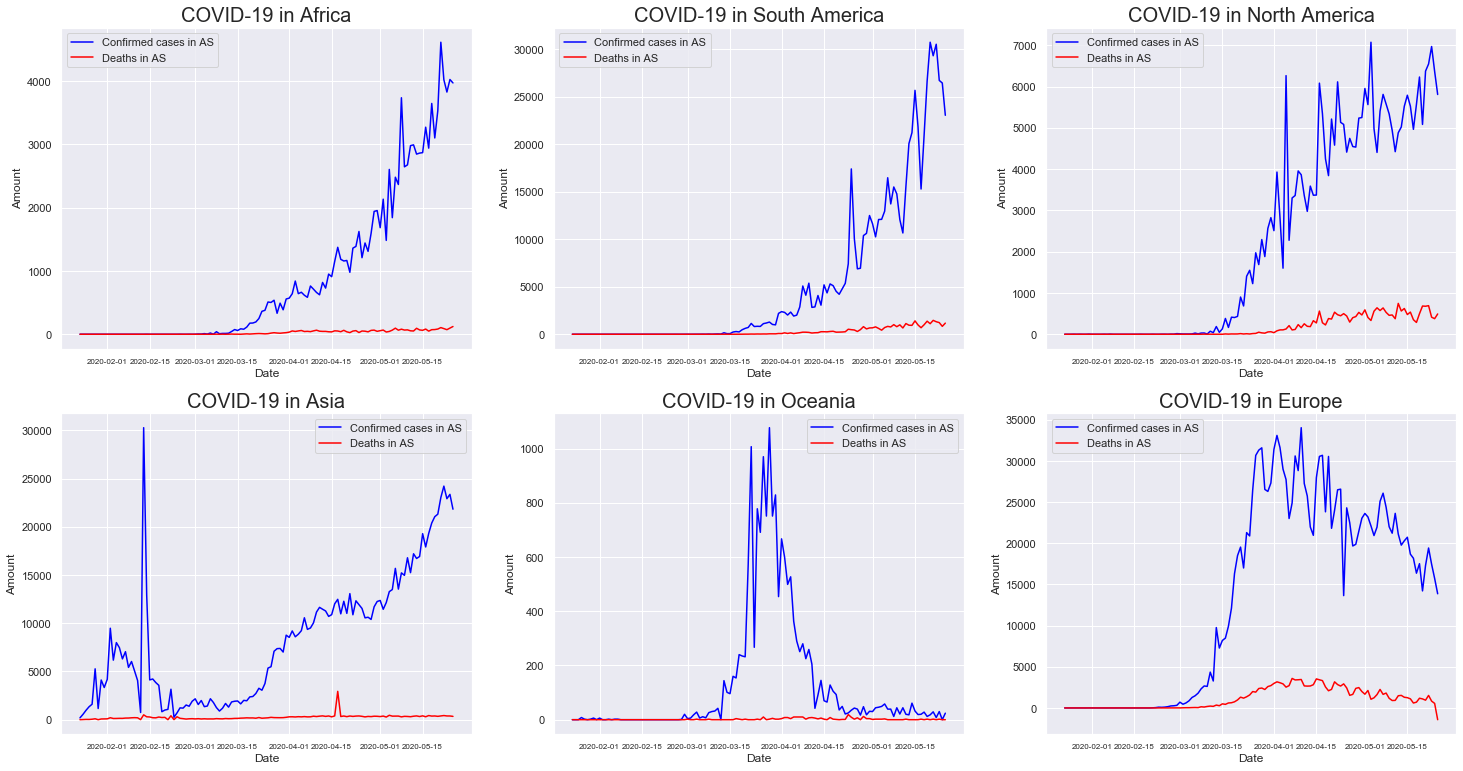

In [22]:
plt.figure(figsize=(25,13))

for i in range(len(continent_list)):
    con_df=continent_df[continent_df.continent==continent_list[i]]
    c=con_df[con_df.Target=="ConfirmedCases"].groupby('Date')['TargetValue'].sum().reset_index()
    f=con_df[con_df.Target=="Fatalities"].groupby('Date')['TargetValue'].sum().reset_index()
    plt.subplot(2,3,i+1)
    sns.lineplot(c.Date,c.TargetValue,label='Confirmed cases in AS',color='Blue')
    sns.lineplot(f.Date, f.TargetValue,label='Deaths in AS',color='Red')
    plt.title('COVID-19 in {}'.format(continent_list[i]),fontsize=20)
    plt.xticks(size=8)
    plt.ylabel('Amount')
    plt.xlabel('Date')


# COVID-19 in The USA 

## USA overall trands of confirmed cases and fatalities

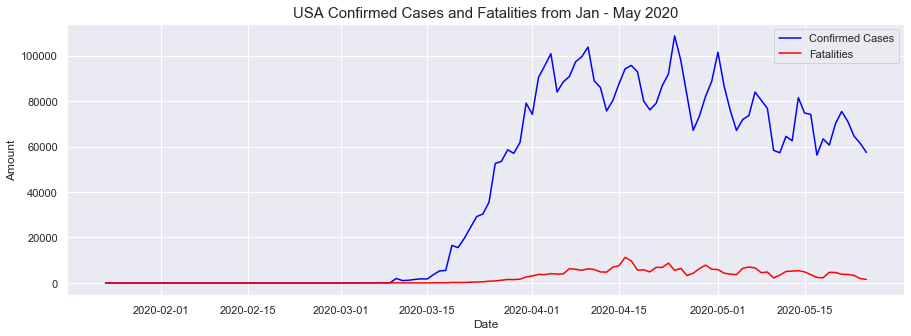

In [23]:
# Separate and obtian confirmed cases and fatalities data 
us_confirm=df[df.Country_Region=='US'][df[df.Country_Region=='US'].Target=='ConfirmedCases']
us_death=df[df.Country_Region=='US'][df[df.Country_Region=='US'].Target=='Fatalities']
# groupby by date
usa_overall_con=pd.DataFrame(us_confirm.groupby('Date')['TargetValue'].sum()).reset_index()
usa_overall_fa=pd.DataFrame(us_death.groupby('Date')['TargetValue'].sum()).reset_index()
# let us plot
plt.figure(figsize=(15,5))
sns.lineplot(usa_overall_con.Date,usa_overall_con.TargetValue,label='Confirmed Cases',color='blue')
sns.lineplot(usa_overall_fa.Date,usa_overall_fa.TargetValue,label='Fatalities',color='red')
plt.legend()
plt.ylabel('Amount')
plt.title('USA Confirmed Cases and Fatalities from Jan - May 2020',fontsize=15)
plt.show()

## By States

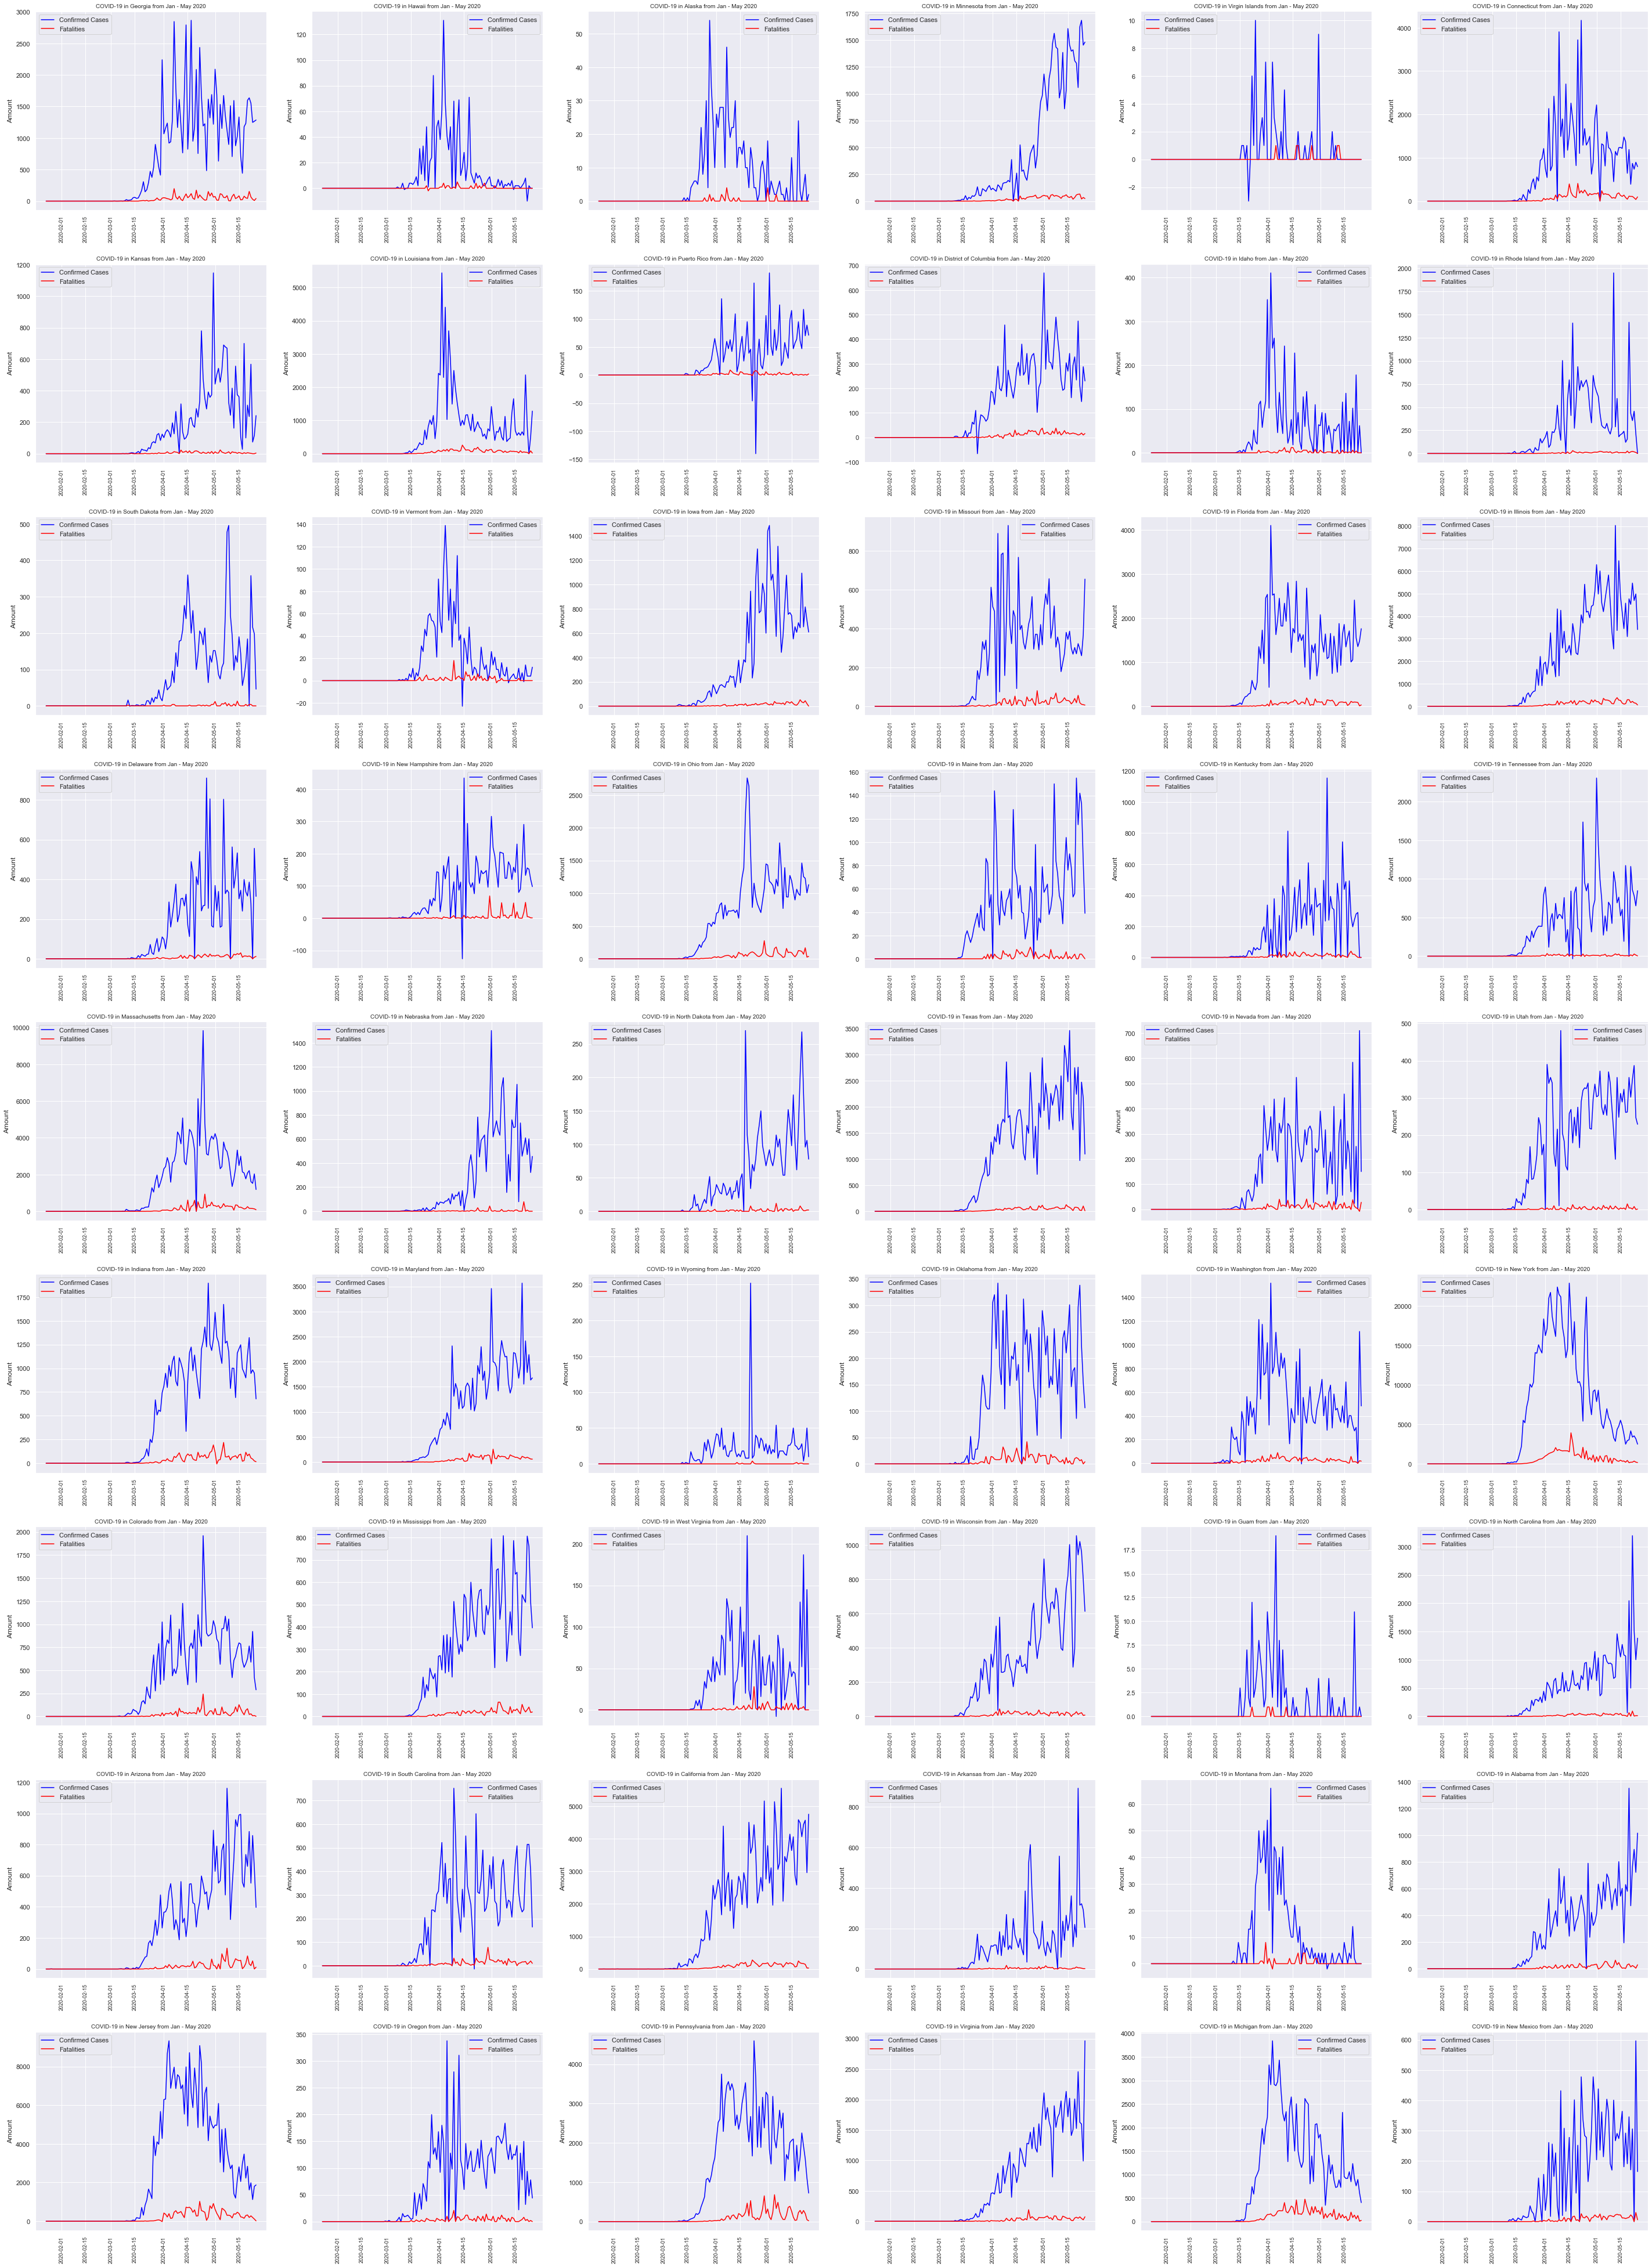

In [24]:
# trends By the states
State=list(set(df[df.Country_Region=="US"].Province_State))[1:]
plt.figure(figsize=(40,60))
for i in range(len(State)):
    plt.subplot(10,6,i+1)
    c=us_confirm[us_confirm.Province_State==State[i]].groupby('Date')['TargetValue'].sum().reset_index()
    f=us_death[us_death.Province_State==State[i]].groupby('Date')['TargetValue'].sum().reset_index()
    plt.plot(c.Date,c.TargetValue,label='Confirmed Cases',color='blue')
    plt.plot(f.Date,f.TargetValue,label='Fatalities',color='red')
    plt.legend(loc='best')
    plt.title('COVID-19 in {} from Jan - May 2020'.format(State[i]),size=10)
    plt.xticks(rotation=90,size=9)
    plt.tight_layout(pad=2.0)
    plt.ylabel('Amount')

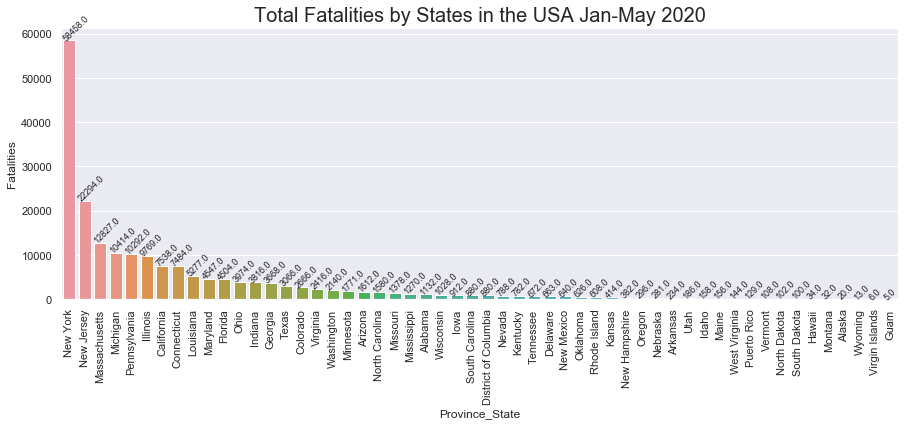

In [25]:
# bar chart of total fatalities in different states  
total_fatality=pd.DataFrame(us_death.groupby('Province_State')['TargetValue'].sum()).sort_values(by='TargetValue',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(total_fatality.index,total_fatality.TargetValue)
plt.ylabel('Fatalities')
plt.xticks(rotation=90)
plt.title('Total Fatalities by States in the USA Jan-May 2020',fontsize=20)
for i in range(len(total_fatality.index)):
    plt.text(i-0.5,total_fatality.TargetValue[i]+1,"{}".format(total_fatality.TargetValue[i]),size=9,rotation=45)
plt.show()

In [26]:
# obtianed usa confirmed cases data and death data 
df_confirm=df[df.Country_Region=="US"][df[df.Country_Region=="US"].Target=='ConfirmedCases'].groupby(['Province_State','County'])['TargetValue'].sum().reset_index()
df_fatality=df[df.Country_Region=="US"][df[df.Country_Region=="US"].Target=='Fatalities'].groupby(['Province_State','County'])['TargetValue'].sum().reset_index()
#merge two dataframes
usa=pd.merge(df_confirm,df_fatality,on=['Province_State','County'])
# # rename the columns
usa.columns=['name','county', 'Confirmed_Cases','Fatalities']

In [27]:
# groupby states
usa_states=usa.groupby('name')[['Confirmed_Cases','Fatalities']].sum().reset_index()
# Load the data for states' latitude and longitude
usa_location=pd.read_csv(path+'usa_State_locaiton.csv')
# merge two dataframes
usa_map_df=pd.merge(usa_states,usa_location,on='name')
usa_map_df.columns=['NAME', 'Confirmed_Cases', 'Fatalities', 'code', 'latitude','longitude']
usa_map_df=usa_map_df[usa_map_df.NAME!='Hawaii']
usa_map_df=usa_map_df[usa_map_df.NAME!='Alaska']

In [28]:
# Load cb_2018_us_state_20m shapefile
# b_2018_us_state_20m file source :https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
geo_usa = geopandas.read_file(path+'cb_2018_us_state_20m')
# merge usa data and shapefile
geo_merge=geo_usa.merge(usa_map_df,on='NAME')

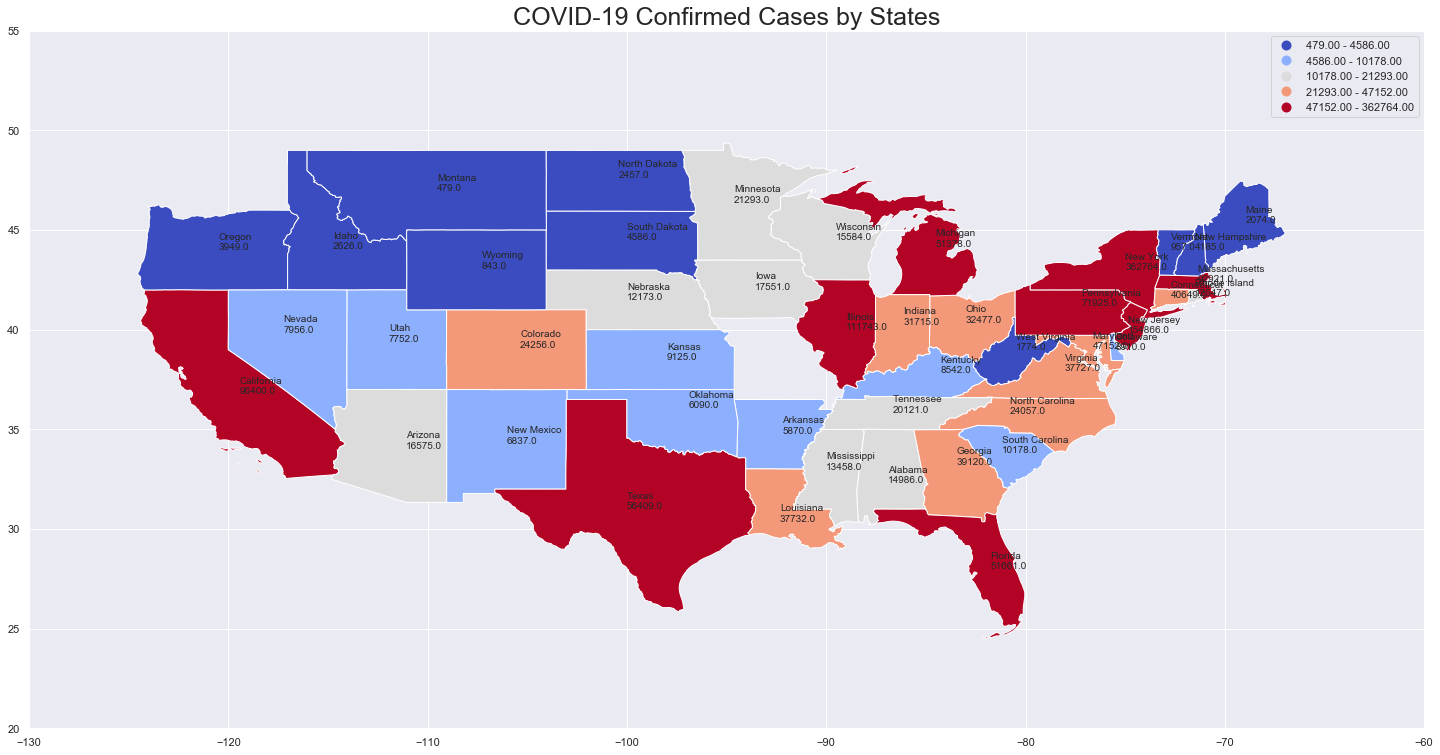

In [29]:
# plot confirmed cases world map 
geo_merge.plot(column='Confirmed_Cases', scheme="quantiles",figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
for i in range(len(geo_merge)):
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n{}".format(geo_merge.NAME[i],geo_merge.Confirmed_Cases[i]),size=10)
plt.title('COVID-19 Confirmed Cases by States',fontsize=25)
plt.show()

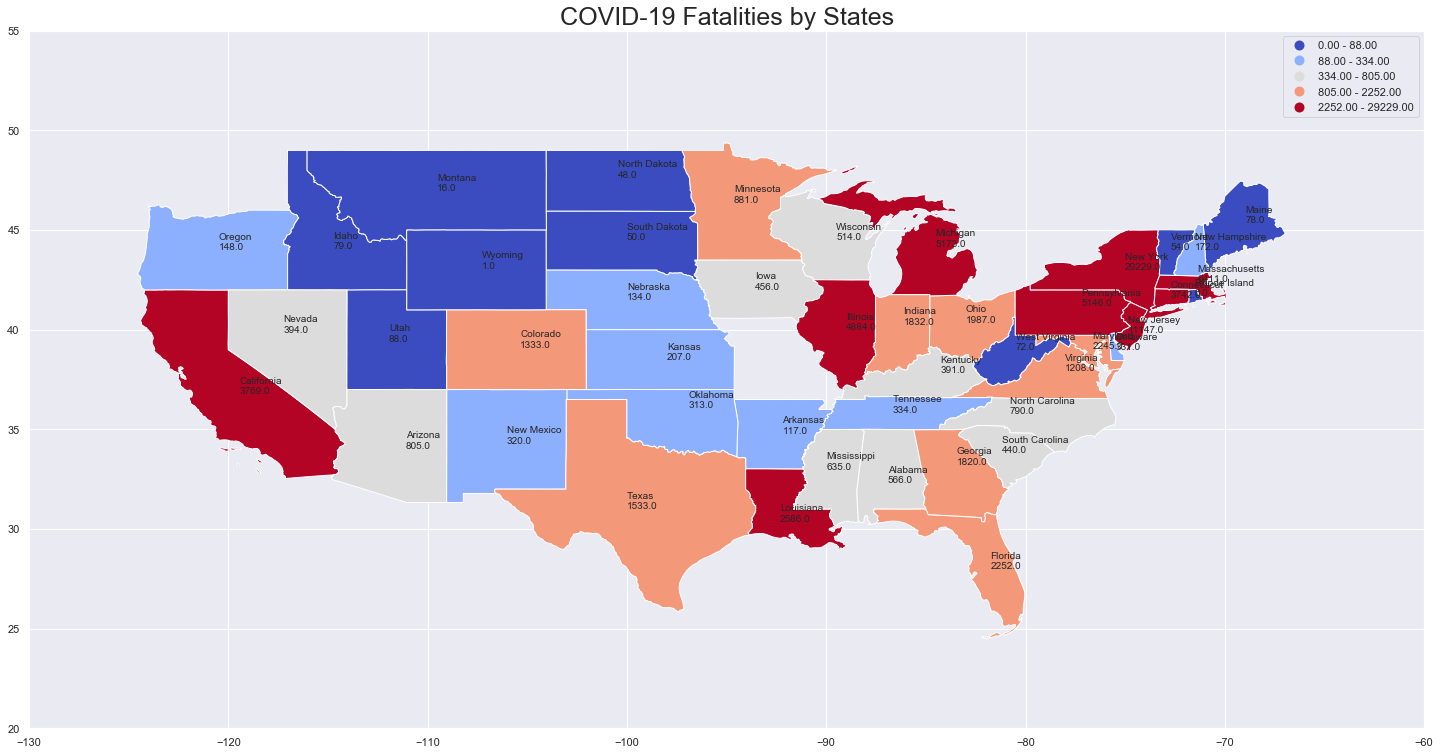

In [41]:
# plot confirmed cases world map 
geo_merge.plot(column='Fatalities', scheme="quantiles",figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
for i in range(len(geo_merge)):
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n{}".format(geo_merge.NAME[i],geo_merge.Fatalities[i]),size=10)
plt.title('COVID-19 Fatalities by States',fontsize=25)
plt.show()

## By county

In [31]:
# load the shapefile 
geo_county=geopandas.read_file(path+'cb_2018_us_county_20m')
# # rename columns
geo_county.columns=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'county', 'LSAD',
       'ALAND', 'AWATER', 'geometry']

#merge cb_2018_us_county_20m file with usa dta 
geo_county=geo_county.merge(usa,on='county').dropna(axis=0).sort_values(by='Confirmed_Cases',ascending=False).reset_index()

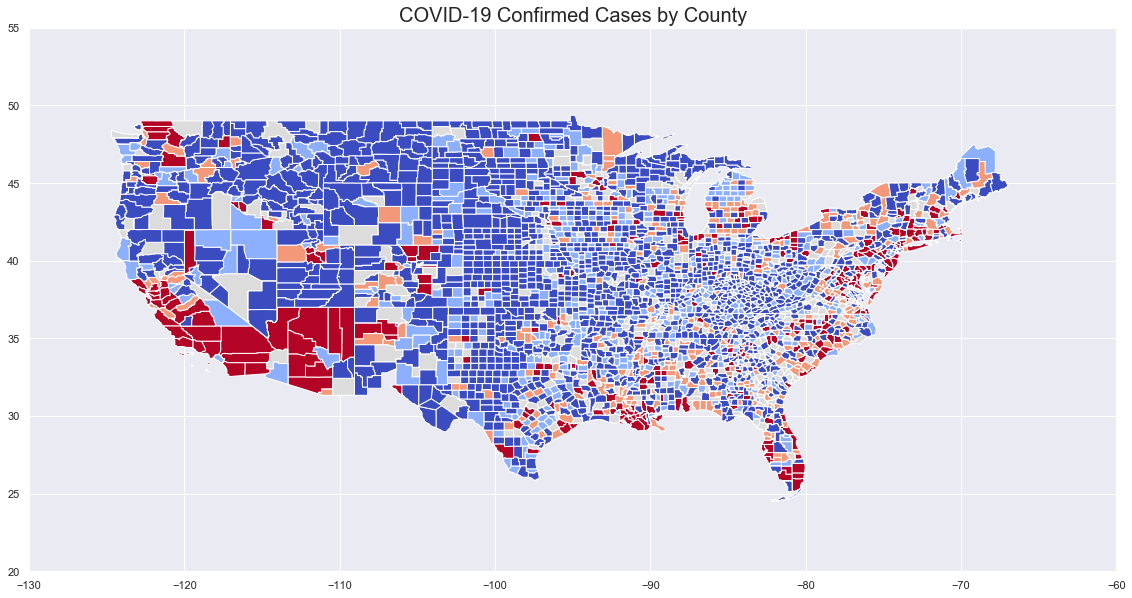

In [32]:
geo_county.plot(column='Confirmed_Cases',scheme="quantiles",figsize=(25,10),cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('COVID-19 Confirmed Cases by County',fontsize=20)
plt.show()

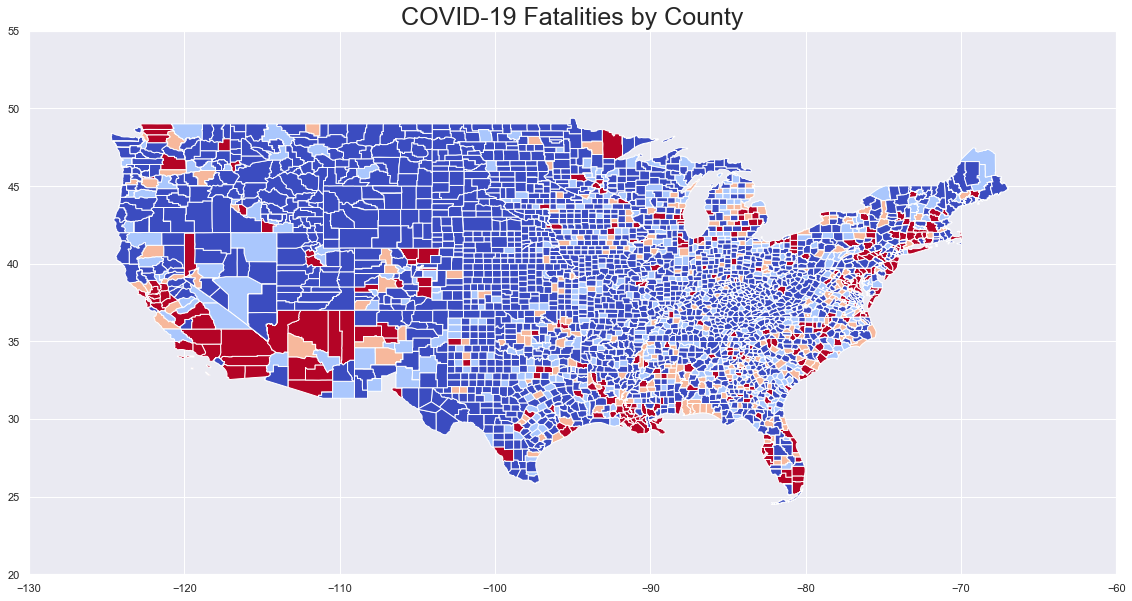

In [33]:
geo_county.plot(column='Fatalities',scheme="quantiles",figsize=(25,10),cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('COVID-19 Fatalities by County',fontsize=25)
plt.show()

## New York City 

In [34]:
# data is fron nyc health department
# data for NYC boroughs
nyc_link='https://raw.githubusercontent.com/nychealth/coronavirus-data/master/boro/boroughs-case-hosp-death.csv'
nyc=pd.read_csv(nyc_link)
# rearrange the date a little bit 
nyc['Date']=pd.to_datetime(nyc.DATE_OF_INTEREST)

In [35]:
# create features list 
boroughs=[['BK_CASE_COUNT', 'BK_DEATH_COUNT'], 
          ['BX_CASE_COUNT', 'BX_DEATH_COUNT'], 
          ['MN_CASE_COUNT',  'MN_DEATH_COUNT'], 
          ['QN_CASE_COUNT', 'QN_DEATH_COUNT'], 
          ['SI_CASE_COUNT',  'SI_DEATH_COUNT']]

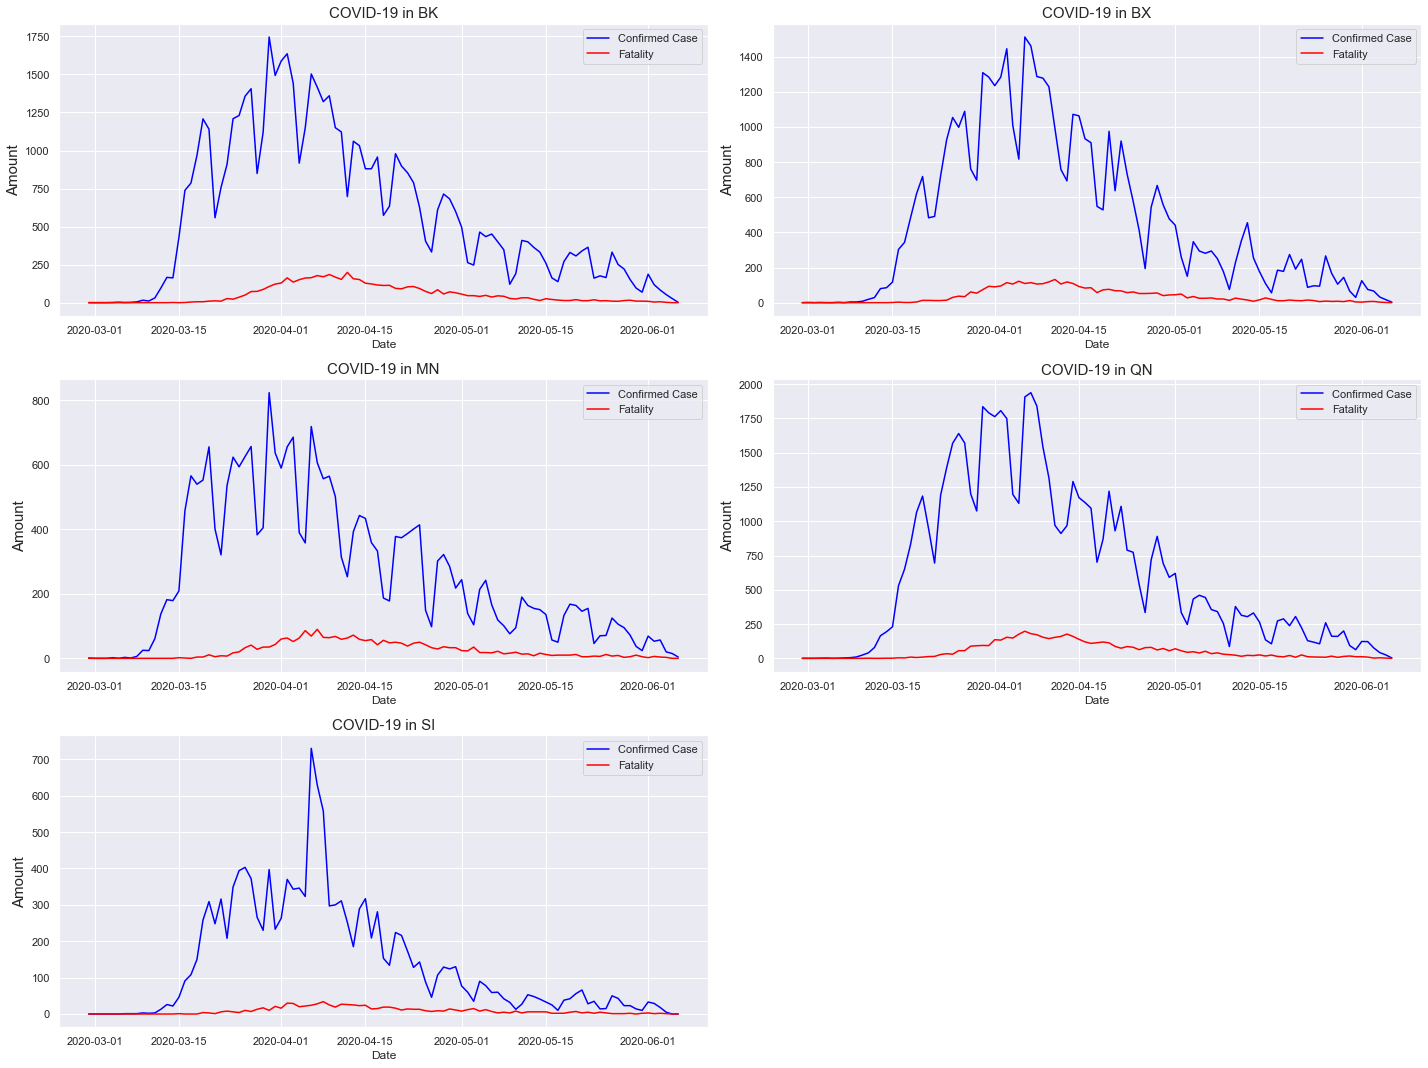

In [36]:
# COVID-19 confirmed cases and fatalities trends in NYC 
plt.figure(figsize=(20,15))
for i in range(len(boroughs)):
    plt.subplot(3,2,i+1)
    sns.lineplot(nyc.Date,nyc[boroughs[i][0]],color='blue',label='Confirmed Case')
    sns.lineplot(nyc.Date,nyc[boroughs[i][1]],color='red',label='Fatality')
    plt.ylabel('Amount',fontsize=15)
    plt.xticks()
    plt.tight_layout()
    plt.title('COVID-19 in {}'.format(boroughs[i][0][:2]),fontsize=15)

In [37]:
# obtian the sum of confirmed cases and fatalities in different boroughs
nyc_con=[]
nyc_fa=[]
for i in boroughs:
    nyc_con.append(sum(nyc[i[0]]))
    nyc_fa.append(sum(nyc[i[1]]))
nyc_con,nyc_fa

([56390, 46026, 25497, 62223, 13573], [5193, 3597, 2333, 5127, 833])

In [42]:
# load the data from geopandas.datasets
nyc_shp = geopandas.read_file(geopandas.datasets.get_path('nybb'))
nyc_shp

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

In [43]:
# create a dataframe
con_fa_nyc=pd.DataFrame()
con_fa_nyc['BoroName']=nyc_shp.BoroName
con_fa_nyc['Confirmed_Cases']=nyc_con
con_fa_nyc['Fatalities']=nyc_fa
con_fa_nyc['longitude']=[920000,1030000,985000,960000,1020000]
con_fa_nyc['latitude']=[160000,200000,180000,220000,250000]

In [44]:
# merge con_fa_nyc and nyc_shp
nyc_shp=nyc_shp.merge(con_fa_nyc,on='BoroName')
nyc_shp

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  Confirmed_Cases  \
0  MULTIPOLYGON (((970217.022 145643.332, 970227....            56390   
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...            46026   
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...            25497   
3  MULTIPOLYGON (((981219.056 188655.316, 980940....            62223   
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...            13573   

   Fatalities  longitude  latitude  
0        5193     920000    160000  
1        3597    1030000    200000  
2        2333     985000    180000  
3        5127     960000    220000  
4         833    1020000    250000

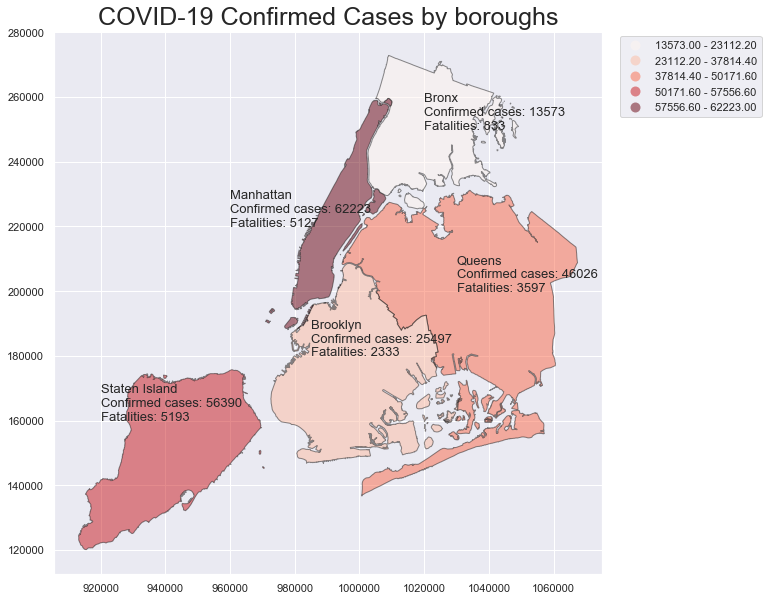

In [45]:
#Map of NYC
#Add background tiles to plot
ax = nyc_shp.plot(column='Confirmed_Cases',figsize=(10, 10), alpha=0.5, edgecolor='k', cmap='Reds',legend=True,scheme="quantiles")
for i in range(len(nyc_shp)):
    plt.text(nyc_shp.longitude[i],nyc_shp.latitude[i],"{}\nConfirmed cases: {}\nFatalities: {}".format(nyc_shp.BoroName[i],nyc_shp.Confirmed_Cases[i],nyc_shp.Fatalities[i]),size=13)
plt.title('COVID-19 Confirmed Cases by boroughs',fontsize=25)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.3,1))
plt.show()    
